In [2]:
import numpy as np
from scipy.stats.mstats import mode
from copy import deepcopy
import pandas as pd
import time
%matplotlib inline
from helper import *

In [3]:
df_train = load_train_data()

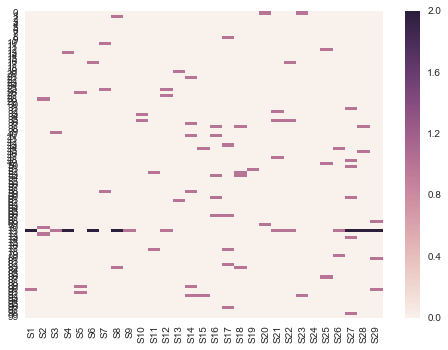

In [5]:
import seaborn as sns
df = df_train[['S'+str(i) for i in xrange(1, 30)]][:100]

_ = sns.heatmap(df)

In [74]:
# Nearest neighbors model
adjacency_list = {
    1: [2, 4, 35],
    2: [1, 34, 35, 36, 41],
    3: [4, 8],
    4: [1, 3],
    5: [7, 45],
    6: [8, 12],
    7: [5, 55],
    8: [3, 6],
    9: [12, 44],
    10: [11, 55],
    11: [10, 13],
    12: [6, 9],
    13: [11, 39],
    14: [16, 54],
    15: [14, 16],
    16: [14, 15, 17],
    17: [16, 56],
    18: [19, 56],
    19: [18, 20],
    20: [19, 21],
    21: [20, 22, 23],
    22: [21, 23, 43],
    23: [21, 24],
    24: [23, 25],
    25: [24, 26],
    26: [25, 27],
    27: [26, 28, 29],
    28: [27, 47],
    29: [27, 30],
    30: [29, 31],
    31: [30, 32],
    32: [31, 33],
    33: [32, 34, 35],
    34: [2, 33, 35, 36, 41],
    35: [1, 2, 34, 36, 41],
    36: [2, 34, 35, 41],
    37: [36, 38],
    38: [37, 40],
    39: [13, 43],
    40: [38],
    41: [2, 36, 42],
    42: [41, 46],
    43: [22, 39],
    44: [9, 45],
    45: [5, 44],
    46: [42],
    47: [28, 48],
    48: [47, 49],
    49: [48, 50],
    50: [49, 51],
    51: [50, 52, 53],
    52: [50, 51, 53],
    53: [51, 52, 54],
    54: [53, 14],
    55: [7, 10],
    56: [17, 18]
}

In [158]:

threshold = 12 # will produce the same like above

threshold = 20 # a bigger list

def compute_adjlist(threshold):
    # computing the adjacency list based on distance
    for key in xrange(56):
        node = key + 1
        adjacency_list[node] = []
        # go through all other nodes, if distance is below threshold, fine!
        for other_key in xrange(56):
            if other_key == key:
                continue

            a = np.array([df_sensors.loc[key].X, df_sensors.loc[key].Y])
            b = np.array([df_sensors.loc[other_key].X, df_sensors.loc[other_key].Y])
            dist = np.linalg.norm(a - b, ord=1)

            if dist < threshold:
                adjacency_list[node].append(other_key + 1)
                
    return adjacency_list
    
adjacency_list = compute_adjlist(27.) # best model
print adjacency_list

{1: [2, 3, 4, 8, 33, 34, 35, 36, 41, 42], 2: [1, 3, 4, 34, 35, 36, 37, 41, 42, 46], 3: [1, 2, 4, 6, 8, 12, 35], 4: [1, 2, 3, 6, 8, 35, 41], 5: [7, 9, 10, 44, 45, 55], 6: [3, 4, 8, 9, 12, 44], 7: [5, 10, 11, 44, 45, 55], 8: [1, 3, 4, 6, 9, 12], 9: [5, 6, 8, 12, 44, 45], 10: [5, 7, 11, 13, 39, 55], 11: [7, 10, 13, 39, 43, 55], 12: [3, 6, 8, 9, 44, 45], 13: [10, 11, 22, 39, 43, 55], 14: [15, 16, 17, 52, 53, 54, 56], 15: [14, 16, 17, 54, 56], 16: [14, 15, 17, 18, 53, 54, 56], 17: [14, 15, 16, 18, 19, 54, 56], 18: [16, 17, 19, 20, 21, 56], 19: [17, 18, 20, 21, 22, 23, 56], 20: [18, 19, 21, 22, 23, 24, 43, 56], 21: [18, 19, 20, 22, 23, 24, 25, 39, 43], 22: [13, 19, 20, 21, 23, 24, 39, 43], 23: [19, 20, 21, 22, 24, 25, 26, 43], 24: [20, 21, 22, 23, 25, 26, 27], 25: [21, 23, 24, 26, 27, 28, 29], 26: [23, 24, 25, 27, 28, 29, 30, 47], 27: [24, 25, 26, 28, 29, 30, 31, 47, 48], 28: [25, 26, 27, 29, 30, 47, 48, 49], 29: [25, 26, 27, 28, 30, 31, 32, 47], 30: [26, 27, 28, 29, 31, 32], 31: [27, 29, 30

In [159]:
# compute weights based on distance
def compute_invdist_weights(adjacency_list):
    df_sensors = pd.read_csv('data/sensor-coordinates.txt')
    df_sensors.columns = ['SID', 'X', 'Y']

    weight_list = {}
    for key in adjacency_list.keys():
        weight_list[key] = []
        b = np.array([df_sensors.loc[key - 1].X, df_sensors.loc[key - 1].Y])
        for el in adjacency_list[key]:
            # manhattan distance
            a = np.array([df_sensors.loc[el - 1].X, df_sensors.loc[el - 1].Y])
            dist = np.linalg.norm(a - b, ord=1)

            # inverse distance weighting
            weight_list[key].append(1.0 / dist)

        # scale it accordingly
        weight_list[key] = np.array(weight_list[key])
        weight_list[key] = weight_list[key] / np.sum(weight_list[key])
    return weight_list

In [160]:
weight_list = compute_invdist_weights(adjacency_list)
print weight_list

{1: array([ 0.17543772,  0.09576491,  0.17543772,  0.06582782,  0.06617797,
        0.07029072,  0.14840706,  0.06839097,  0.0785363 ,  0.05572882]), 2: array([ 0.17496312,  0.07003462,  0.10500255,  0.09562852,  0.11826339,
        0.09213714,  0.06360257,  0.14180344,  0.08145165,  0.05711301]), 3: array([ 0.11561967,  0.08478413,  0.25459191,  0.13312487,  0.25423282,
        0.08737328,  0.07027332]), 4: array([ 0.21652198,  0.12994373,  0.26025453,  0.08935994,  0.13003543,
        0.09922467,  0.07465973]), 5: array([ 0.27133525,  0.09625235,  0.08810761,  0.14214537,  0.27168401,
        0.13047541]), 6: array([ 0.13807213,  0.09066424,  0.28984444,  0.13046034,  0.26368077,
        0.08727809]), 7: array([ 0.27963461,  0.13446627,  0.09084044,  0.09613211,  0.13990711,
        0.25901946]), 8: array([ 0.08276648,  0.26475934,  0.13247309,  0.29103003,  0.09033415,
        0.13863691]), 9: array([ 0.08874403,  0.13599573,  0.09378339,  0.26917387,  0.27486866,
        0.13743433

In [161]:
# compute for each node a reliability score
def compute_reliability(df):
    reliability_weights = {}
    for i in xrange(56):
        sid = 'S'+str(i+1)
        idxs = df[sid] == -1
        reliability_weights[i+1] =  int((1. - np.sum(idxs * 1.) / (1. * df.count()[0])) * 10) * 1.# // 100
    return reliability_weights

def compute_reliability_weights(df, adjacency_list):
    
    reliability_factors = compute_reliability(df)

    print reliability_factors
    weight_list = {}
    for key in adjacency_list.keys():
        weight_list[key] = []
        for el in adjacency_list[key]:
            # inverse distance weighting
            weight_list[key].append(reliability_factors[el])

        # scale it accordingly
        weight_list[key] = np.array(weight_list[key])
        weight_list[key] = weight_list[key] / np.sum(weight_list[key])
    return weight_list
reliability_weights = compute_reliability_weights(df_train, adjacency_list)
reliability_weights

{1: 9.0, 2: 9.0, 3: 9.0, 4: 9.0, 5: 9.0, 6: 6.0, 7: 9.0, 8: 9.0, 9: 4.0, 10: 9.0, 11: 9.0, 12: 8.0, 13: 4.0, 14: 4.0, 15: 9.0, 16: 9.0, 17: 6.0, 18: 9.0, 19: 9.0, 20: 4.0, 21: 9.0, 22: 9.0, 23: 5.0, 24: 9.0, 25: 9.0, 26: 5.0, 27: 9.0, 28: 5.0, 29: 3.0, 30: 4.0, 31: 5.0, 32: 4.0, 33: 9.0, 34: 4.0, 35: 9.0, 36: 8.0, 37: 4.0, 38: 4.0, 39: 8.0, 40: 9.0, 41: 5.0, 42: 9.0, 43: 9.0, 44: 4.0, 45: 6.0, 46: 4.0, 47: 10.0, 48: 4.0, 49: 3.0, 50: 9.0, 51: 9.0, 52: 9.0, 53: 9.0, 54: 9.0, 55: 9.0, 56: 9.0}


{1: array([ 0.1125,  0.1125,  0.1125,  0.1125,  0.1125,  0.05  ,  0.1125,
         0.1   ,  0.0625,  0.1125]),
 2: array([ 0.12857143,  0.12857143,  0.12857143,  0.05714286,  0.12857143,
         0.11428571,  0.05714286,  0.07142857,  0.12857143,  0.05714286]),
 3: array([ 0.15254237,  0.15254237,  0.15254237,  0.10169492,  0.15254237,
         0.13559322,  0.15254237]),
 4: array([ 0.16071429,  0.16071429,  0.16071429,  0.10714286,  0.16071429,
         0.16071429,  0.08928571]),
 5: array([ 0.2195122 ,  0.09756098,  0.2195122 ,  0.09756098,  0.14634146,
         0.2195122 ]),
 6: array([ 0.20930233,  0.20930233,  0.20930233,  0.09302326,  0.18604651,
         0.09302326]),
 7: array([ 0.19565217,  0.19565217,  0.19565217,  0.08695652,  0.13043478,
         0.19565217]),
 8: array([ 0.2       ,  0.2       ,  0.2       ,  0.13333333,  0.08888889,
         0.17777778]),
 9: array([ 0.21428571,  0.14285714,  0.21428571,  0.19047619,  0.0952381 ,
         0.14285714]),
 10: array([ 0.1875

In [162]:
# Several possibilities to average the result among the neighbors:
#    - cumulative sum of neighbors (v1)
#    - average (truncated) (v2)
#    - average (raw) (v3) 
#    - average (rounded) (v4)
#    - average with inv distance weight, larger adj list (raw) (v5 Leo) ** best (20. euclidean)
def fill_neighbors(row, col_name, adjacency_list):
    if row[col_name] == -1:
        new_value = 0.
        count = 0
        col_ind = int(col_name[1:])
        pos = 0
        for n in adjacency_list[col_ind]:
            if row[n] != -1:
                new_value += row[n] * weight_list[col_ind][pos]
                count += weight_list[col_ind][pos] # + 1
            pos = pos + 1
            
        # if some neighbours were working return their average (raw)
        if count:
            return round(new_value / (1. * count))
        
        # if no neighbours were working, return 0 (most frequent value)
        return new_value
    else:
        return row[col_name]



In [163]:
col_names = ['S'+str(i) for i in xrange(1, 57)]
df_train_neighbors_avg = df_train.copy()

In [164]:
for col_name in col_names:
    start = time.time()
    df_train_neighbors_avg[col_name] = df_train.apply(lambda row: fill_neighbors(row, col_name, adjacency_list),axis=1)
    total_time = time.time() - start
    print 'Col {} computed in {}'.format(col_name, total_time)

Col S1 computed in 1.26983189583
Col S2 computed in 1.02723884583
Col S3 computed in 0.898528814316
Col S4 computed in 1.32541394234
Col S5 computed in 0.956779956818
Col S6 computed in 2.90486502647
Col S7 computed in 0.865741968155
Col S8 computed in 0.970973014832
Col S9 computed in 3.18105888367
Col S10 computed in 0.918576002121
Col S11 computed in 0.828794956207
Col S12 computed in 1.18708205223
Col S13 computed in 3.62233400345
Col S14 computed in 4.24609208107
Col S15 computed in 1.00753211975
Col S16 computed in 0.760680913925
Col S17 computed in 3.04136395454
Col S18 computed in 0.95379114151
Col S19 computed in 0.851037025452
Col S20 computed in 4.46872997284
Col S21 computed in 1.08219003677
Col S22 computed in 1.02289819717
Col S23 computed in 4.31780910492
Col S24 computed in 0.928390979767
Col S25 computed in 0.843271017075
Col S26 computed in 3.24072480202
Col S27 computed in 0.932601928711
Col S28 computed in 3.18478608131
Col S29 computed in 4.2467648983
Col S30 compu

In [167]:
# Checking that all the values are filled (i.e no -1 left)
cum_sum = 0
for col in col_names:
    cum_sum += len(df_train_neighbors_avg[df_train_neighbors_avg[col] == -1])
print cum_sum

0


In [168]:
create_submission_file(df_train_neighbors_avg, 'nearest_v8Leo.csv')

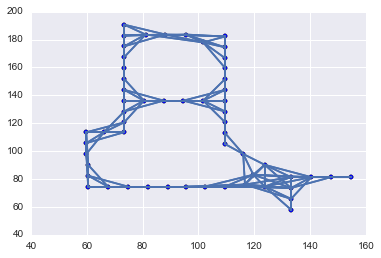

In [126]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# plot the network
%matplotlib inline
df_sensors = pd.read_csv('data/sensor-coordinates.txt')
df_sensors.columns = ['SID', 'X', 'Y']
plt.scatter(df_sensors.X, df_sensors.Y)

# plot lines for network
for key in adjacency_list.keys():
    a = np.array([df_sensors.loc[key - 1].X, df_sensors.loc[key - 1].Y])
    
    for key2 in adjacency_list[key]:
        b = np.array([df_sensors.loc[key2 - 1].X, df_sensors.loc[key2 - 1].Y])
        plt.plot([a[0], b[0]], [a[1], b[1]], color=sns.color_palette()[0])
    